## Introduction

From the dataset [Food Deserts in the USA](https://www.kaggle.com/tcrammond/food-access-and-food-deserts?select=food_access_research_atlas.csv) dataset on Kaggles: "the USDA defines living in a food desert as:

living more than one mile from a supermarket in urban/suburban areas, and more than 10 miles from a supermarket in rural areas"

## Goal


Our classification problem will identify if a county is a food desert or not. We will predict this using demographic information, academic performance, income etc. To test our results, we will use labels that contain flags to indicate if a county is a food desert.

In [251]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import tree #decision tree
# pd.set_option('display.max_colwidth', 0) #text reflow in columns

## Dataset

In [252]:
combined_df = pd.read_csv("../data/combined_data.csv")
combined_df.head()

,Educ_countyid,Educ_fips,Educ_gap_est,Educ_tot_asmts,Educ_cellcount,Educ_mn_asmts,Educ_mn_avg_ol,Educ_mn_grd_ol,Educ_mn_coh_ol,Educ_mn_mth_ol,...,Food_TractBlack,Food_TractAsian,Food_TractNHOPI,Food_TractAIAN,Food_TractOMultir,Food_TractHispanic,Food_TractHUNV,Food_TractSNAP,County,State
0,1001,1.0,0.0,72864.0,96.0,759.000000,5.636815,1.048619,-0.092830,-0.435624,...,803.583333,39.500000,2.666667,19.333333,111.250000,109.166667,90.083333,223.500000,Autauga,AL
1,1003,1.0,0.0,213214.0,96.0,2220.979167,5.428993,0.832481,-0.051916,-0.611446,...,551.774194,43.483871,2.870968,39.225806,204.967742,257.806452,72.322581,208.741935,Baldwin,AL
2,1005,1.0,0.0,26521.0,96.0,276.260417,3.692509,0.956793,0.129474,-0.743482,...,1430.555556,11.888889,3.222222,12.666667,128.000000,154.111111,89.111111,233.000000,Barbour,AL
3,1007,1.0,0.0,25678.0,96.0,267.479167,4.235791,0.996612,0.021188,-0.888118,...,1261.750000,5.500000,3.250000,16.000000,97.000000,101.500000,74.750000,281.250000,Bibb,AL
4,1009,1.0,0.0,71940.0,96.0,749.375000,4.689641,0.866955,0.091370,-1.011810,...,84.555556,13.000000,4.222222,34.111111,336.777778,514.000000,91.444444,322.222222,Blount,AL


## Identifying labels

There are lots of columns in our dataset. Let's find the ones that we will use as labels:

In [253]:
food_doc = pd.read_csv("../data/food_access_variable_lookup.csv")

In [254]:
desert_flags_labels = food_doc[food_doc['Description'].str.contains('food desert')]
desert_flags_labels

,Field,LongName,Description
9,LILATracts_1And10,Low income and low access tract measured at 1 ...,Flag for food desert when considering low acce...
10,LILATracts_halfAnd10,Low income and low access tract measured at 1/...,Flag for food desert when considering low acce...
11,LILATracts_1And20,Low income and low access tract measured at 1 ...,Flag for food desert when considering low acce...
12,LILATracts_Vehicle,Low income and low access tract using vehicle ...,Flag for food desert when considering vehicle ...


We idetified the following as our labels:

In [255]:
desert_flags_label_list = desert_flags_labels['Field'].tolist()
desert_flags_label_list = list(map(lambda label: 'Food_' + label, desert_flags_label_list) )
print(desert_flags_label_list)

['Food_LILATracts_1And10', 'Food_LILATracts_halfAnd10', 'Food_LILATracts_1And20', 'Food_LILATracts_Vehicle']


### Average of Boolean Values
From 0-Data_Exploration_And_Cleaning.ipynb : For boolean type variables, the resulting average will represent a percentage (in decimal form) of how many tracts in that county had a value of 1 before combining.

In [256]:
desert_flags = combined_df[desert_flags_label_list]
desert_flags.head()

,Food_LILATracts_1And10,Food_LILATracts_halfAnd10,Food_LILATracts_1And20,Food_LILATracts_Vehicle
0,0.166667,0.166667,0.083333,0.166667
1,0.096774,0.096774,0.096774,0.064516
2,0.333333,0.333333,0.111111,0.222222
3,0.000000,0.000000,0.000000,0.250000
4,0.000000,0.000000,0.000000,0.222222


### Indicators of Food Access
From the documentation, we know the following:
- Accessibility to sources of healthy food, as measured by distance to a store or by the number of stores in an area.
- Individual-level resources that may affect accessibility, such as family income or vehicle availability.
- Neighborhood-level indicators of resources, such as the average income of the neighborhood and the availability of public transportation.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12afdc8e0>,
      dtype=object)

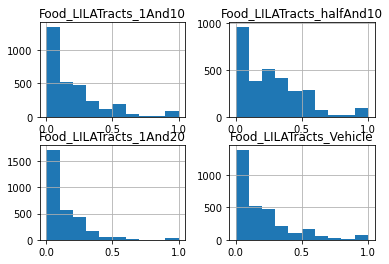

In [257]:
desert_flags.hist()

## Binning
To indicate how much of a food desert a Census-Tract is, we create 5 bins ranging from 0-20%, 20-40% etc

In [258]:
def bin_desert(percent, bins):
    for i in range(1, bins+1):
        if percent <= i/bins and percent >= 0:
            return i
        
    return bins+1 # 6th bin for invalid input (negatives or greater than 1 percents)

bin_desert(0.0, 5)

1

In [259]:
desert_flags = desert_flags.apply(lambda x : x.apply( lambda y : bin_desert(y, 5)))
desert_flags.head()

,Food_LILATracts_1And10,Food_LILATracts_halfAnd10,Food_LILATracts_1And20,Food_LILATracts_Vehicle
0,1,1,1,1
1,1,1,1,1
2,2,2,1,2
3,1,1,1,2
4,1,1,1,2


In [260]:
combined_df[desert_flags_label_list] = desert_flags
# combined_df[desert_flags_label_list]

## Dealing with NaN values

In [261]:
total_rows = combined_df.shape[0]
nan_rows = combined_df[combined_df.isna().any(axis=1)].shape[0]
(nan_rows/total_rows)*100

3.8272816486751715

3.83 percent of all the rows contain some undefined data.

In [262]:
combined_df[combined_df.isna().any(axis=1)].head()

,Educ_countyid,Educ_fips,Educ_gap_est,Educ_tot_asmts,Educ_cellcount,Educ_mn_asmts,Educ_mn_avg_ol,Educ_mn_grd_ol,Educ_mn_coh_ol,Educ_mn_mth_ol,...,Food_TractBlack,Food_TractAsian,Food_TractNHOPI,Food_TractAIAN,Food_TractOMultir,Food_TractHispanic,Food_TractHUNV,Food_TractSNAP,County,State
67,2230,2.0,0.0,325.0,67.0,4.850746,7.531304,NaN,NaN,NaN,...,0.000000,5.000000,1.000000,34.000000,43.000000,21.000000,26.000000,13.000000,Skagway Municipality,AK
159,6003,6.0,0.0,533.0,61.0,8.737705,5.046593,NaN,NaN,NaN,...,0.000000,7.000000,0.000000,240.000000,47.000000,84.000000,7.000000,23.000000,Alpine,CA
217,8003,8.0,0.0,7778.0,42.0,185.190476,5.493467,NaN,NaN,-0.193893,...,43.000000,37.000000,4.750000,108.250000,781.000000,1777.500000,131.750000,348.000000,Alamosa,CO
218,8005,8.0,0.0,308032.0,37.0,8325.189189,5.996026,0.930396,NaN,0.192001,...,395.285714,197.802721,7.755102,29.680272,431.333333,717.836735,84.755102,123.122449,Arapahoe,CO
219,8007,8.0,0.0,4491.0,43.0,104.441860,5.731876,NaN,NaN,-0.201018,...,9.250000,22.250000,1.500000,56.750000,322.250000,537.000000,30.500000,125.000000,Archuleta,CO


In [263]:
# NaN values: find better way to deal with these rows. Currently setting all to zero.
# Maybe add a flag to indicate it is a row with insuffiect info?
combined_df = combined_df.fillna(0)

## Principal Component Analysis (PCA)

In [270]:
# desert_flags_label_list
classes = combined_df[desert_flags_label_list]
features = combined_df.copy();
features = features.drop(columns=desert_flags_label_list + ['County', 'State'])
# print(features)

X_train, X_test, Y_train, Y_test = train_test_split(features, classes, test_size=0.1, random_state=0) 

Then, we standardize the data. Here, we are tranforming the data to unit scale, where mean = 0 and variance = 1. This will help increase the performance of the model.

In [265]:
# scaler = StandardScaler()
# # Fit on training set only.
# scaler.fit(X_train)
# # Apply transform to both the training set and the test set.
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

Apply PCA by making an instance of the model and fitting PCA on the training set

In [266]:
# # Make an instance of the Model and fit
# pca = PCA(.95)
# pca.fit(X_train)
# # Apply transform to both the training set and the test set.
# X_train = pca.transform(X_train)
# X_test = pca.transform(X_test)

In [274]:
pca = PCA()
classifier = tree.DecisionTreeClassifier()

# transform / fit
X_transformed = pca.fit_transform(X_train)
# Y_transformed = pca.fit_transform(Y_train)

# print(Y_transformed)

# print(X_transformed.shape)
# print(Y_transformed.shape)

classifier.fit(X_transformed, Y_train)

DecisionTreeClassifier()

In [ ]:
# predict "new" data
# (I'm faking it here by using the original data)
# newdata = iris.data

# # transform new data using already fitted pca
# # (don't re-fit the pca)
# newdata_transformed = pca.transform(newdata)

# # predict labels using the trained classifier

# pred_labels = classifier.predict(newdata_transformed)